# Comparison with different CPU Frequencies

In [57]:
def parse_line(txtf):
    f = open(txtf, 'r')
    x = f.read().split('\n')
    x=filter(None,x)
    x = [int(i.split(':')[1]) for i in x]
    return x

In [62]:
knl_cpu=parse_line('cpu_knl.txt')
has_cpu=parse_line('cpu_has.txt')
#print len(knl_cpu),knl_cpu
#print "\n"
#print len(has_cpu),has_cpu

In [80]:
import numpy as np
knl_cpu1=np.mean(np.asarray(knl_cpu).reshape(-1, 3), axis=1)
has_cpu1=np.mean(np.asarray(has_cpu).reshape(-1, 3), axis=1)
has_io=[1.1*1024,939,1.0*1024,861,890,968,863,896,933,900,829,901,840,894,778,845,
        783,861,871,780,770,669,814,812,793,623,788,719,727,604,
686,693,714,546,665,687,637,602,600]
knl_io=[306,298,326,304,300,291,275,275,288,262,271,267,244,250,245,229,213,226]
knl_io_avg=np.mean(np.asarray(knl_io).reshape(-1, 3), axis=1)
has_io_avg=np.mean(np.asarray(has_io).reshape(-1, 3), axis=1)
knl_io_min=np.min(np.asarray(knl_io).reshape(-1, 3), axis=1)
has_io_min=np.min(np.asarray(has_io).reshape(-1, 3), axis=1)
knl_io_max=np.max(np.asarray(knl_io).reshape(-1, 3), axis=1)
has_io_max=np.max(np.asarray(has_io).reshape(-1, 3), axis=1)
knl_cpu1 =[i/1000000 for i in knl_cpu1]
has_cpu1 =[i/1000000 for i in has_cpu1]

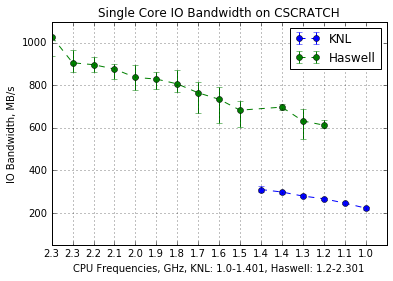

In [81]:
import matplotlib.pyplot as plt
%matplotlib inline 
all_cpu=[2.3010000000000002, 2.2999999999999998, 2.2000000000000002, 
         2.1000000000000001, 2.0, 1.8999999999999999, 
         1.8, 1.7, 1.6000000000000001, 1.5, 1.401, 
         1.3999999999999999, 1.3, 1.2,1.1000000000000001, 1.0]
has_x=[0,1,2,3,4,5,6,7,8,9,11,12,13]
knl_x=[10,11,12,13,14,15]
has_labels=["{0:.1f}".format(x) for x in has_cpu1]
knl_labels=["{0:.1f}".format(x) for x in knl_cpu1]
#plt.xticks(has_x,has_labels)

plt.errorbar(knl_x,knl_io_avg, [knl_io_avg-knl_io_min, knl_io_max-knl_io_avg], fmt='--o', label="KNL")

plt.errorbar(has_x,has_io_avg, [has_io_avg-has_io_min, has_io_max-has_io_avg], fmt='--o', label="Haswell")

#plt.xticks(knl_x,knl_labels)
all_labels=["{0:.1f}".format(x) for x in all_cpu]

plt.xticks(range(16),all_labels)
plt.xlabel('CPU Frequencies, GHz, KNL: 1.0-1.401, Haswell: 1.2-2.301')
plt.ylabel('IO Bandwidth, MB/s')
plt.title('Single Core IO Bandwidth on CSCRATCH')
#plt.yscale('logit')
plt.grid(True)
plt.ylim(50,1100)
plt.legend()

In [96]:
def plt_fit(has_cpu1,has_io_avg,xlabel):
    from scipy import stats
    import sys
    has_cpu1=np.asarray(has_cpu1)
    has_io_avg=np.asarray(has_io_avg)
    slope, intercept, r_value, p_value, std_err = stats.linregress(has_cpu1,has_io_avg)
    print 'slope:%.2f'%slope
    print 'intercept:%.2f'%intercept
    print 'r-square:%.2f'%(r_value*r_value)
    predict_y = slope*has_cpu1+intercept
    x=has_cpu1
    y=has_io_avg
    pred_error = y - predict_y
    degrees_of_freedom = len(x) - 2
    residual_std_error = np.sqrt(np.sum(pred_error**2) / degrees_of_freedom)
    # Plotting
    plt.plot(x, y, 'o',label='data')
    plt.xlabel(xlabel)
    plt.ylabel('IO Bandwidth MB/s')
    plt.plot(x, predict_y, 'k-',label='fitting,r^2=%.2f'%(r_value*r_value))
    plt.legend(loc='upper left')
    plt.show()
    return slope,intercept


slope:308.93
intercept:239.39
r-square:0.94


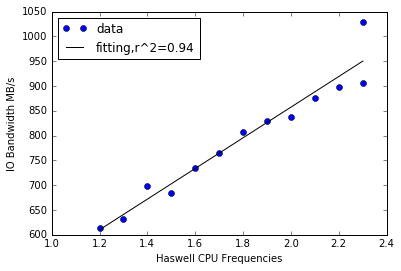

In [97]:
has_k,has_b=plt_fit(has_cpu1,has_io_avg,'Haswell CPU Frequencies')

slope:197.22
intercept:27.29
r-square:0.98


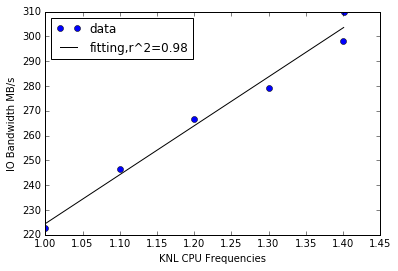

In [98]:
knl_k,knl_b=plt_fit(knl_cpu1,knl_io_avg,"KNL CPU Frequencies")

In [117]:
#print has_k,has_b,knl_k,knl_b
cpu_same=[1.2,1.3,1.4]
a=0
for ic in cpu_same:
    a+=(has_k*ic+has_b)/(knl_k*ic+knl_b)
print "With same CPU frequencies, the IO performance ratio between Haswell and KNL: %.2f"%(a/3)
print "The peak single core IO performance ratio between Haswell and KNL: %.2f"%(max(has_io_avg)/max(knl_io_avg))

With same CPU frequencies, the IO performance ratio between Haswell and KNL: 2.26
The peak single core IO performance ratio between Haswell and KNL: 3.32


# Conclusion 1: KNL's single IO performance is more correlated with CPU frequencies than Haswell, r-square 0.98> 0.94

# Conclusion 2: With same CPU frequencies, the IO performance ratio between Haswell and KNL: 2.26


# Conclusion 3: The single core peak IO performance ratio between Haswell and KNL: 3.32